### Este modelo será el baseline. Incluye:
#### - Malla de parámetros.
#### - Datos de "Primer procesado de datos": sin variables categóricas y nan rellenos con media/moda.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Exportar modelos
import pickle

# Pipeline
from sklearn.pipeline import Pipeline

# CV
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

# Modelos
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [96]:
# Cargamos datos
data = pd.read_csv('../data/processed/primer_procesado_entrenamiento.csv', sep = '\t')
target = pd.read_csv('../data/processed/primer_procesado_target.csv', sep = '\t')

In [52]:
# Cambiamos los nombres de las features para que no contengan espacios ni caracteres especiales
data.columns = ['pressure', 'mass_flux', 'x_e_out', 'D_e', 'D_h', 'length', 'chf_exp']


In [53]:
# Dividimos en features y target, siendo el target x_e_out [-]
X = data.drop(['x_e_out'], axis = 1)
y = data['x_e_out']
# Luego tendremos que recuperar los nombres originales de las features

In [54]:
# Dividimos entre train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)


In [55]:
from lightgbm import LGBMRegressor
#Initialize and train the model
model = LGBMRegressor(n_estimators=129, random_state=0, n_jobs=-1, verbose = 0)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
model.fit(X_train, y_train)

# Make predictions on the test set and evaluate
preds_test = model.predict(X_test)
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, preds_test)))

#0.07593529428957042 129 es el mejor n_estimators

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You 

In [56]:
# Creamos un primer pipe
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', Ridge())]
                )

In [57]:
# Creamos una malla de parámetros para cada modelo a probar

param_grid_linear_regression = {
    'estimator' : [LinearRegression()],
    'estimator__fit_intercept': [True, False],  # Probar con o sin intercepto
    'estimator__normalize': [True, False]  # Probar con o sin normalización de características
}

param_grid_ridge = {
    'estimator' : [Ridge()],
    'estimator__alpha': [0.1, 1.0, 10.0],  # Valores de alpha a probar
    'estimator__solver': ['svd', 'cholesky', 'lsqr']  # Métodos de solución a probar
}

param_grid_lasso = {
    'estimator' : [Lasso()],
    'estimator__alpha': [0.1, 1.0, 10.0],  # Valores de alpha a probar
    'estimator__max_iter': [1000, 2000, 5000]  # Número máximo de iteraciones a probar
}

param_grid_elasticnet = {
    'estimator' : [ElasticNet()],
    'estimator__alpha': [0.1, 1.0, 10.0],  # Valores de alpha a probar
    'estimator__l1_ratio': [0.25, 0.5, 0.75],  # Valores de l1_ratio a probar
    'estimator__max_iter': [1000, 2000, 5000]  # Número máximo de iteraciones a probar
}


param_grid_decision_tree = {
    'estimator' : [DecisionTreeRegressor()],
    'estimator__max_depth': [None, 5, 10, 20],  # Profundidad máxima del árbol a probar
    'estimator__min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'estimator__min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en un nodo hoja
}

param_grid_random_forest = {
    'estimator' : [RandomForestRegressor()],
    'estimator__n_estimators': [10, 50, 100],  # Número de árboles a probar
    'estimator__max_depth': [None, 5, 10, 20],  # Profundidad máxima del árbol a probar
    'estimator__min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'estimator__min_samples_leaf': [1, 2, 4]  # Número mínimo de muestras requeridas en un nodo hoja
}

param_grid_gradient_boosting = {
    'estimator' : [GradientBoostingRegressor()],
    'estimator__n_estimators': [100, 200, 500],  # Número de estimadores a probar
    'estimator__learning_rate': [0.1, 0.01],  # Tasa de aprendizaje a probar
    'estimator__max_depth': [3, 5, 10],  # Profundidad máxima del árbol base a probar
    'estimator__subsample': [0.8, 1.0],  # Proporción de muestras utilizadas para entrenar cada árbol
}

param_grid_adaboost = {
    'estimator' : [AdaBoostRegressor()],
    'estimator__n_estimators': [50, 100, 200],  # Número de estimadores a probar
    'estimator__learning_rate': [0.1, 0.01, 0.005],  # Tasa de aprendizaje a probar
    'estimator__loss': ['linear', 'square', 'exponential']  # Función de pérdida a probar
}

param_grid_xgboost = {
    'estimator' : [XGBRegressor()],
    'estimator__n_estimators': [100, 200, 500],  # Número de árboles a probar
    'estimator__learning_rate': [0.1, 0.01, 0.001],  # Tasa de aprendizaje a probar
    'estimator__max_depth': [3, 5, 10],  # Profundidad máxima del árbol a probar
    'estimator__subsample': [0.8, 1.0],  # Proporción de muestras utilizadas para entrenar cada árbol
}

In [58]:
# Crear espacio de búsqueda
search_space = [
    #param_grid_linear_regression,
    #param_grid_ridge,
    #param_grid_lasso,
    #param_grid_elasticnet,
    #param_grid_decision_tree,
    #param_grid_random_forest,
    #param_grid_gradient_boosting,
    #param_grid_adaboost,
    param_grid_xgboost # El mejor para el primer modelo
    ]

In [59]:
cv = KFold(n_splits=5, shuffle = True, random_state=0)

In [60]:
# Generar la cross-validation
gridsearch = GridSearchCV(
    estimator = pipe,  # Pipeline
    param_grid = search_space,  # Espacio de búsqueda
    cv = cv,  # Validación cruzada
    verbose=2,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)


In [61]:
# Entrenamos la búsqueda
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator', Ridge())]),
             n_jobs=-1,
             param_grid=[{'estimator': [XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=Fals...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                   

In [62]:
# Obtener los mejores hiperparámetros y el mejor modelo
best_params = gridsearch.best_params_
best_model = gridsearch.best_estimator_
print(best_params)
print(best_model)


{'estimator': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), 'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 200, 'estimator__subsample': 0.8}
Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 XGBRegressor(base_score=0.5, booster='gbtree'

In [63]:
# Predecir los valores de salida para los datos de prueba utilizando el mejor modelo
y_pred = model.predict(X_test)

In [64]:
# Evaluar el rendimiento del mejor modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Error cuadrático medio:', mse)
print('Raíz del error cuadrático medio:', np.sqrt(mse))
print('Error absoluto medio:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('Mejores hiperparámetros:', best_params)

Error cuadrático medio: 0.005766168918843666
Raíz del error cuadrático medio: 0.07593529428957042
Error absoluto medio: 0.05171778159789067
R2: 0.46051914147048045
Mejores hiperparámetros: {'estimator': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), 'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator

### Extraemos los mejores hiperparámetros

In [65]:
# Extraemos los mejores hiperparámetros de best_model
best_model_params = best_model.get_params()
print(best_model_params)

{'memory': None, 'steps': [('scaler', StandardScaler()), ('estimator', XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...))], 'verbose': False, 'scaler': StandardScaler(), 'estimator': XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_c

### Representamos la importancia de cada feature

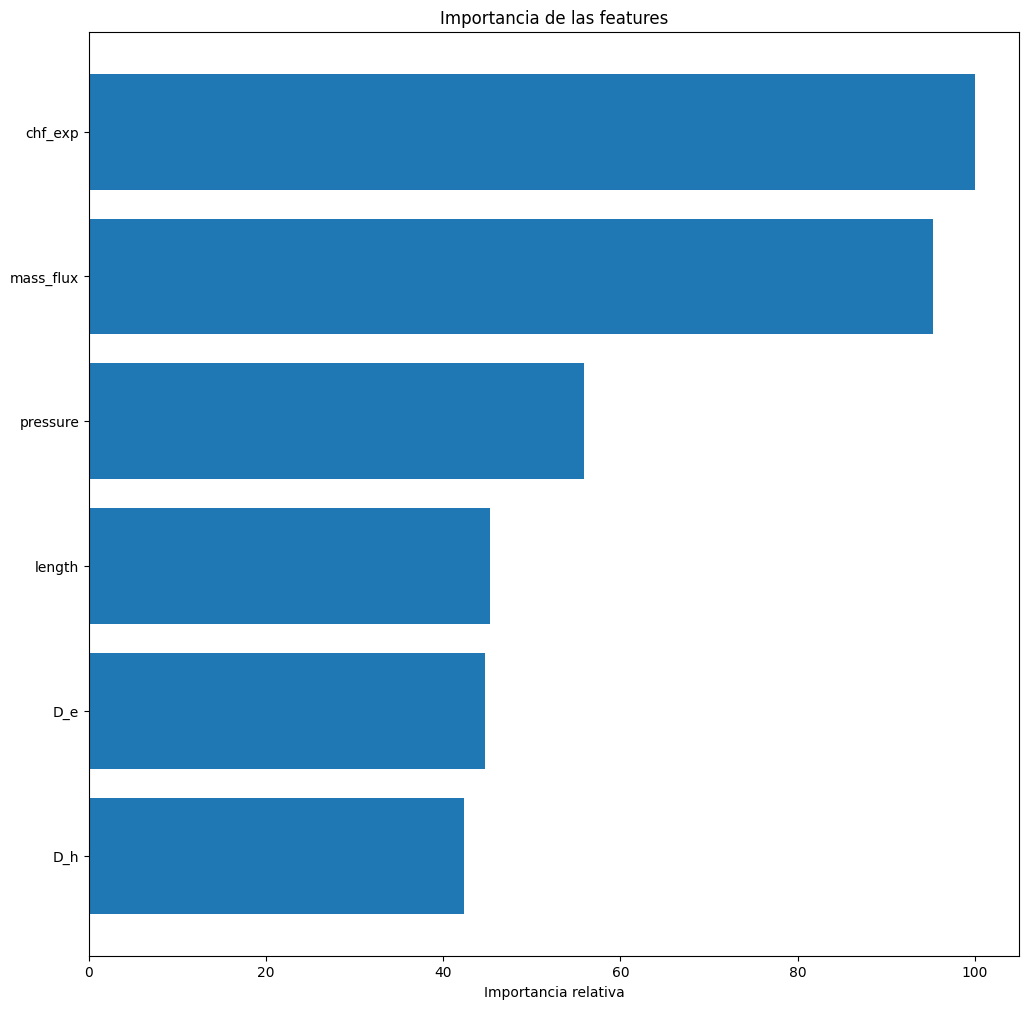

In [66]:
# Extraemos la feature importance del best model
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
feature_names = X.columns
feature_names = feature_names[sorted_idx]
feature_importance = feature_importance[sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5

# Representamos la importancia de las features
plt.figure(figsize=(12, 12))
plt.barh(pos, feature_importance, align='center')
plt.yticks(pos, feature_names)
plt.xlabel('Importancia relativa')
plt.title('Importancia de las features')
plt.show()


### Extraemos todas las métricas para este modelo en formato csv

In [67]:
# Extraemos las métricas de evaluación para todos los modelos del pipeline en formato dataframe y lo pasamos a csv
cv_results = pd.DataFrame(gridsearch.cv_results_)


In [68]:
# Extraemos todas las métricas de evaluación del modelo en formato dataframe y luego lo pasamos a csv
metricas_LGBM = pd.DataFrame({'MSE' : [mse], 'RMSE' : [rmse], 'MAE' : [mae], 'R2' : [r2]})


### Gráficas de resultados

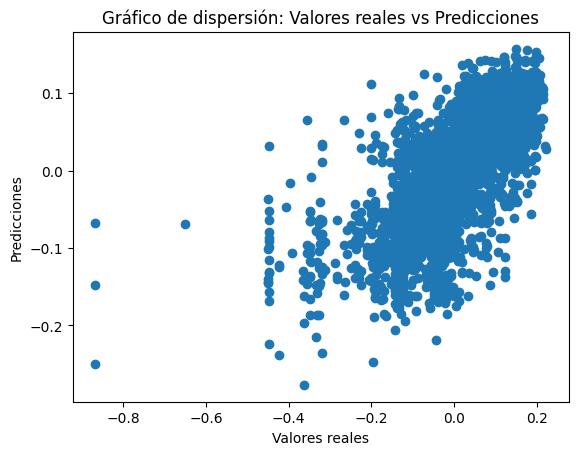

In [102]:
import matplotlib.pyplot as plt

# Obtén las predicciones del modelo


# Traza el gráfico de dispersión
plt.scatter(y_test, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Gráfico de dispersión: Valores reales vs Predicciones')
plt.show()


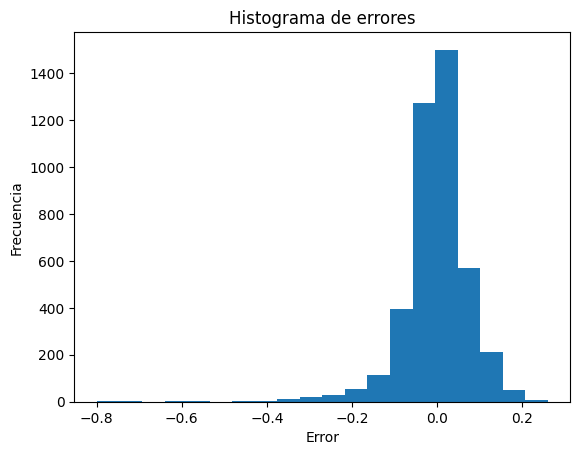

In [103]:
import numpy as np

# Calcula los errores
errores = y_test - y_pred

# Traza el histograma de errores
plt.hist(errores, bins=20)
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Histograma de errores')
plt.show()

In [105]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error'
    )
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Entrenamiento')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Prueba')
    plt.fill_between(
        train_sizes, train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std, alpha=0.1, color='r'
    )
    plt.fill_between(
        train_sizes, test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std, alpha=0.1, color='g'
    )
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Pérdida')
    plt.title('Curva de aprendizaje')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

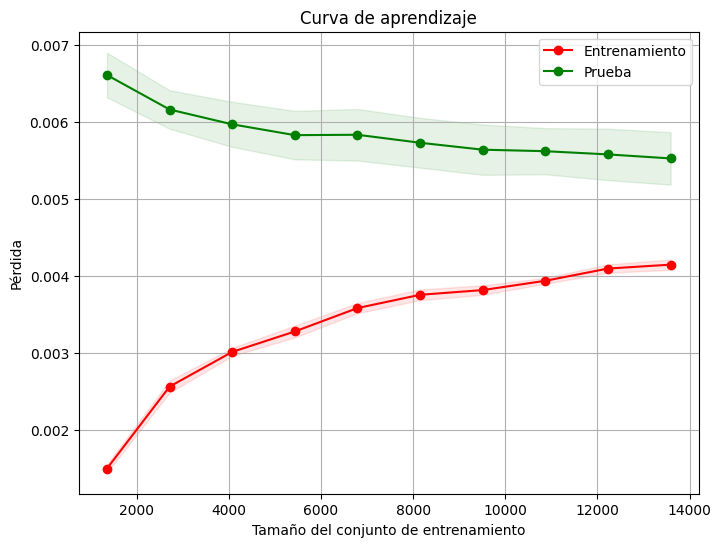

In [106]:
plot_learning_curve(best_model, X_train, y_train, cv=cv)

### Guardamos el mejor modelo en un archivo .pickle
#### (Pendiente de hacer función)

In [69]:
nombre_archivo = '../output/models/primer_procesado_LGBM.pickle'
modelo = model
import pickle
try:
    with open(nombre_archivo, 'wb') as archivo:
        pickle.dump(modelo, archivo)
    print(f"El modelo se ha guardado exitosamente en {nombre_archivo}.")
except IOError:
    print("Error: No se pudo guardar el modelo. Permiso denegado.")

El modelo se ha guardado exitosamente en ../output/models/primer_procesado_LGBM.pickle.


In [70]:
def csv_datos(nombre_archivo, data):
    '''Guarda el dataframe data en un archivo csv con nombre nombre_archivo
    en la carpeta data/processed'''
    ruta_archivo = '../output/reports'
    data.to_csv(ruta_archivo + "/" + nombre_archivo, sep='\t', index=False)

In [71]:
# Guardamos los datos con las métricas en un csv
ruta_archivo = '../output/reports/'
csv_datos("metricas_primer_procesado_LGBM.csv", metricas_LGBM)